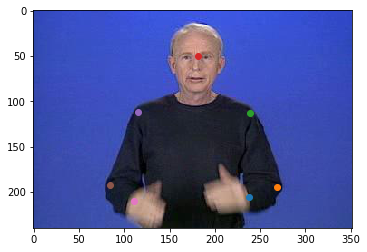

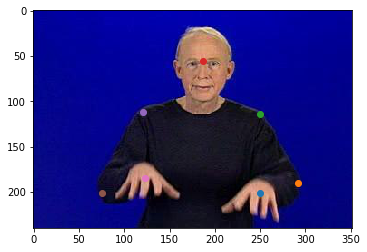

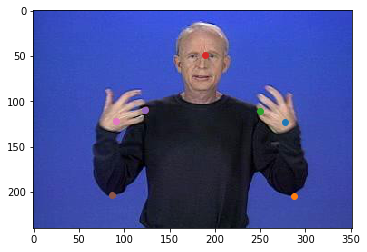

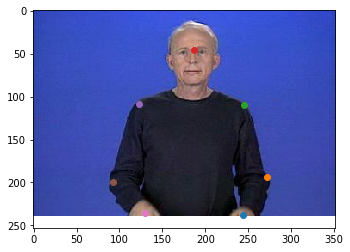

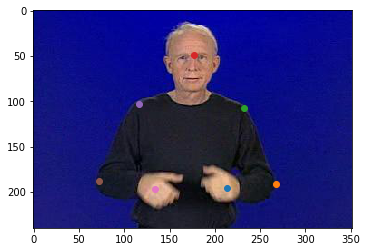

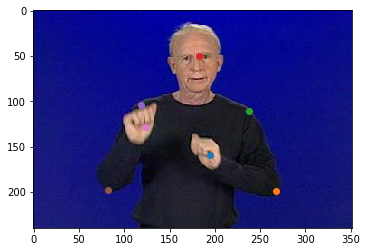

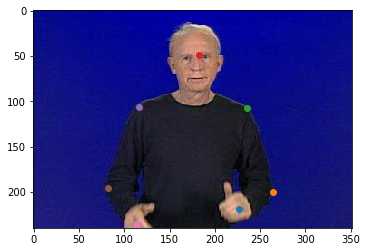

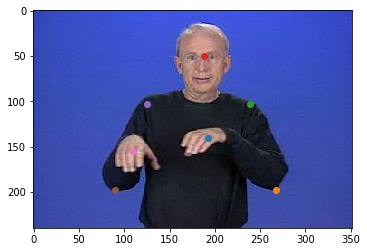

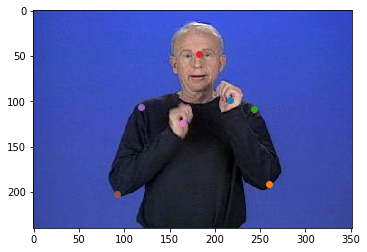

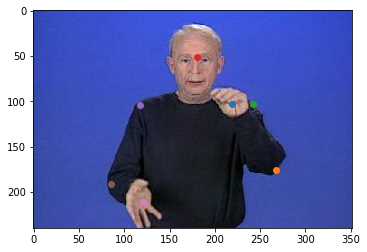

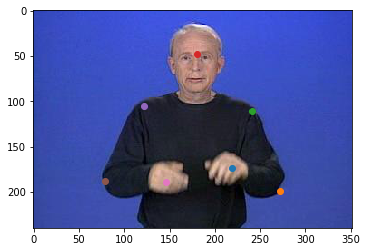

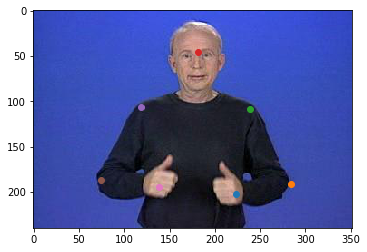

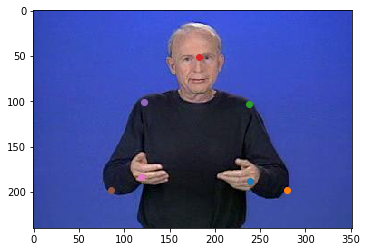

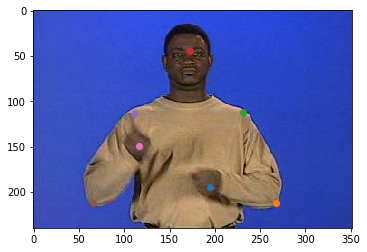

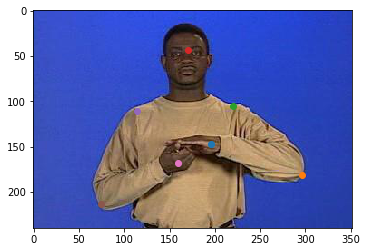

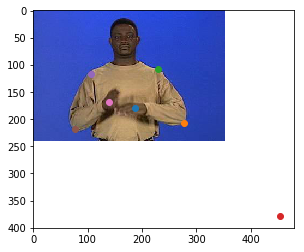

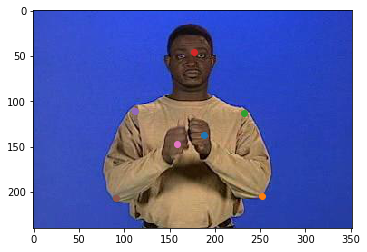

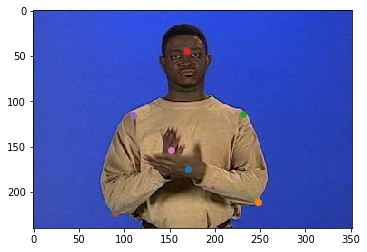

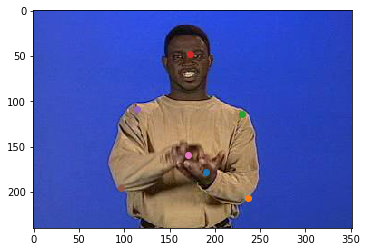

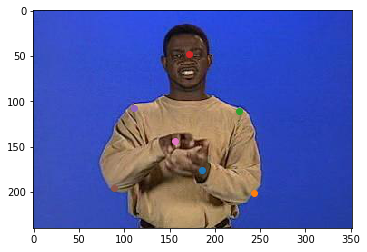

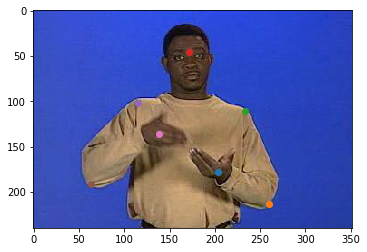

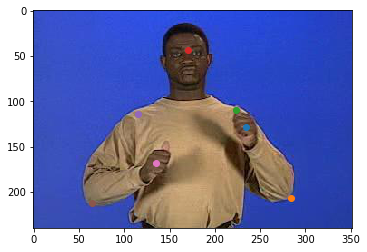

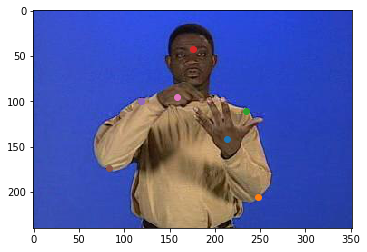

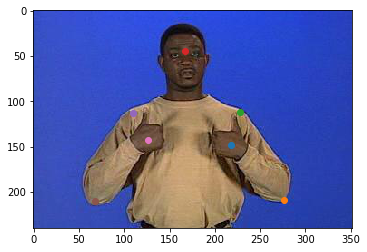

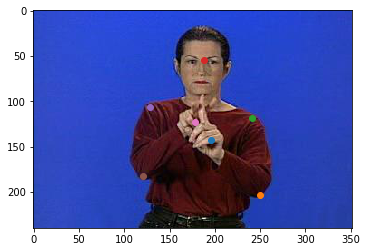

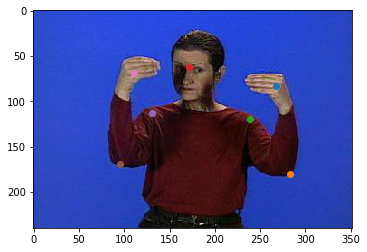

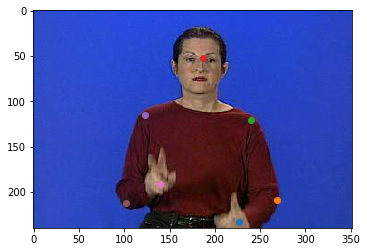

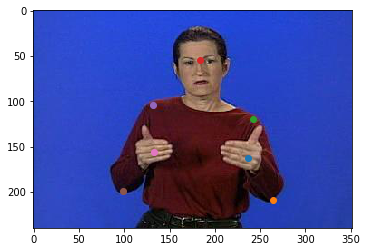

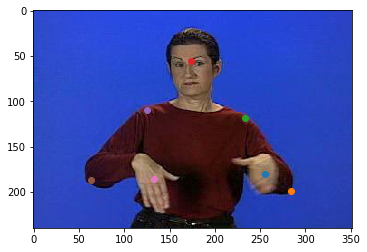

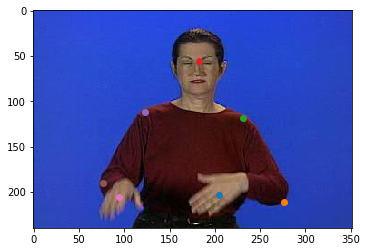

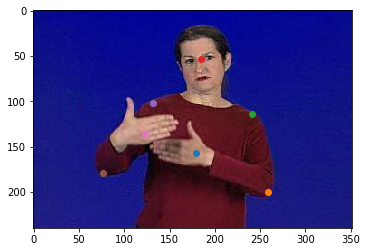

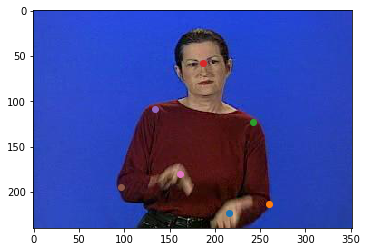

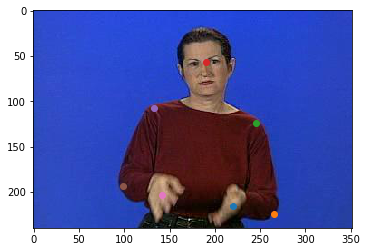

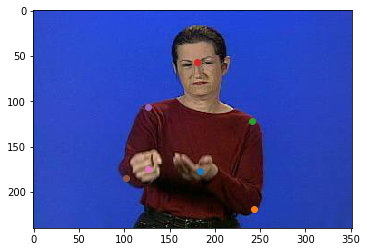

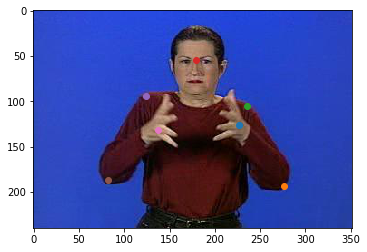

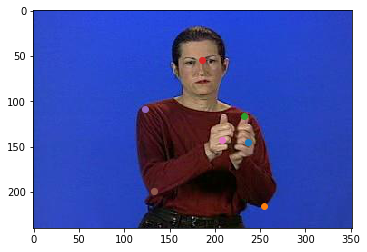

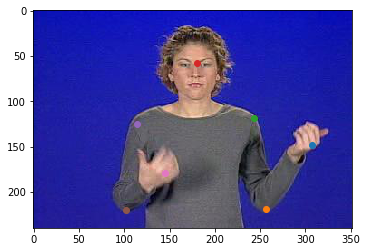

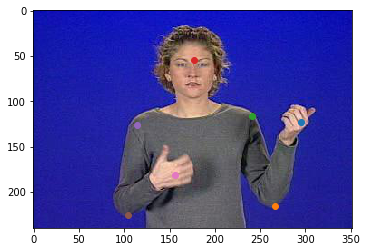

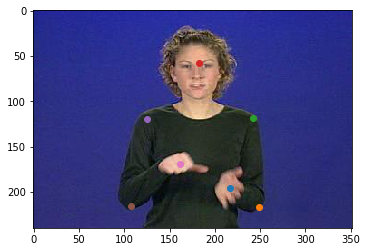

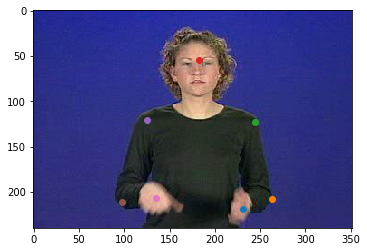

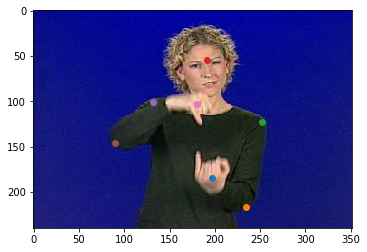

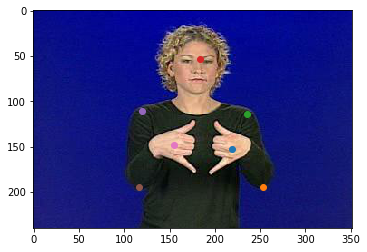

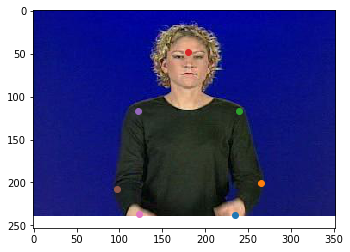

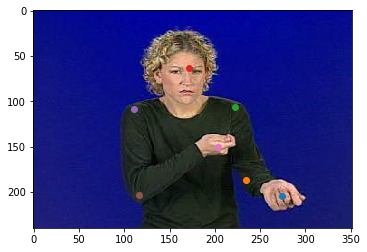

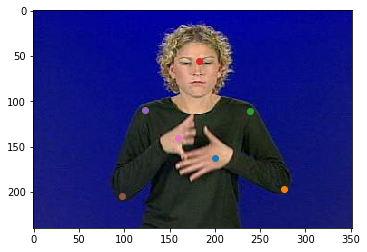

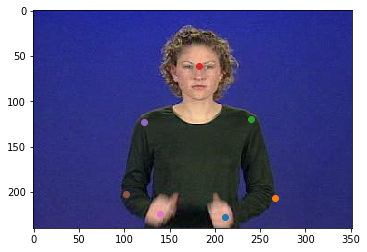

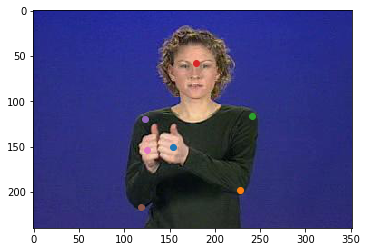

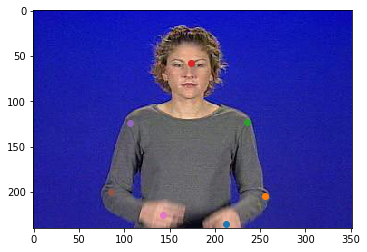

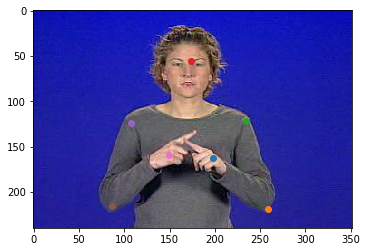

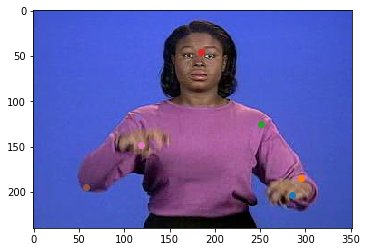

In [1]:
#http://vlm1.uta.edu/~srujana/ASLID/ASL_Image_Dataset.html

basepath='/home/facundo/datasets/pose/aslid/'

import os
import skimage.io
import collections
import numpy as np
import matplotlib.pyplot as plt

def read_image_filenames(annotations_filepath):
    import csv
    f = open(annotations_filepath, 'r')
    annotations_reader = csv.reader(f, delimiter=',')
    return [row[0] for row in annotations_reader]
    



body_parts=['lwri','lelb','lsho','nose','rsho','relb','rwri']
fields=["filename","positions"]
ASLIDImage= collections.namedtuple('ASLIDImage',fields)

filename="train.csv"

annotations_filepath=os.path.join(basepath,filename)

positions=np.loadtxt(annotations_filepath,delimiter=',',usecols=list(range(1,15)))
n,m=positions.shape
positions=positions.reshape(n,m//2,2)
image_filenames=read_image_filenames(annotations_filepath)

samples=[]
for i in range(0,500,10):#positions.shape[0]):
    sample_positions=positions[i,:,:]
    named_positions={}
    for j in range(sample_positions.shape[0]):
        named_positions[body_parts[j]]=sample_positions[j,:]
    sample=ASLIDImage(image_filenames[i],named_positions)
    samples.append(sample)
    
    image_filepath=os.path.join(basepath,'train',sample.filename)
    image=skimage.io.imread(image_filepath)
    plt.imshow(image)
    for position in sample.positions:
        plt.scatter(sample.positions[position][0], sample.positions[position][1])
    plt.show()
    





In [11]:
import os
import skimage.io
import collections
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import metrics

ASLIDImage= collections.namedtuple('ASLIDImage',["filepath","positions"])

class ASLIDIterator(tf.keras.preprocessing.image.Iterator):
    """Iterator yielding data from a Numpy array.
    # Arguments
        basepath: path to folder with aslid images
                  `train`: folder with train images
                  `test`: folder with test images
                  `train.txt`: annotations for train dataset
                  `test.txt`: annotations for test dataset
        dataset: "train" or "test" 
        localization_target: LocalizationTarget subclass to transform the output
        batch_size:
        shuffle:
        seed:
    """
    body_parts=['lwri','lelb','lsho','nose','rsho','relb','rwri']
    
    def __init__(self, basepath,dataset,localization_target,
                 batch_size=32,shuffle=False, seed=None):
        self.localization_target=localization_target
        datasets=['train','test']
        self.sizes={'train':(240,352),'test':(480,640)}
        
        if not dataset in datasets:
            raise ValueError("Dataset \"%s\" is invalid. Options: %s" % (str(dataset),str(datasets)))
        
        self.basepath=basepath
        self.image_size=self.sizes[dataset]

        
        self.images_path=os.path.join(basepath,dataset)
        self.annotations_filepath=os.path.join(basepath,"%s.csv" % dataset)
        
        self.samples=self.read_annotations(self.images_path,self.annotations_filepath)
        super().__init__(len(self.samples), batch_size, shuffle, seed)
        
    def read_annotations(self,images_path,annotations_filepath):
        def read_image_filenames(annotations_filepath):
            import csv
            f = open(annotations_filepath, 'r')
            annotations_reader = csv.reader(f, delimiter=',')
            return [row[0] for row in annotations_reader]
        

        filename="train.csv"

        positions=np.loadtxt(annotations_filepath,delimiter=',',usecols=list(range(1,15)))
        n,m=positions.shape
        positions=positions.reshape(n,m//2,2)
        image_filenames=read_image_filenames(annotations_filepath)

        samples=[]
        for i in range(positions.shape[0]):
            sample_positions=positions[i,:,:]
            named_positions={}
            for j in range(sample_positions.shape[0]):
                named_positions[self.body_parts[j]]=sample_positions[j,:]
            sample=ASLIDImage(os.path.join(self.images_path,image_filenames[i]),named_positions)
            samples.append(sample)
        return samples

    def _get_batches_of_transformed_samples(self, index_array):
        frame_indices=index_array[0]
              
        n=len(frame_indices)
        h,w=self.image_size
        x=np.zeros((n,h,w,3))
        y_dim=self.localization_target.dims()
        y=np.zeros((n,y_dim))
        
        for (i,j) in enumerate(frame_indices):
            sample=self.samples[j]
            image=skimage.io.imread(sample.filepath)

#             image = self.image_data_generator.random_transform(image.astype(K.floatx()))
#             image = self.image_data_generator.standardize(image)
            x[i,:,:,:]=image
            y[i,:]=self.localization_target.frame_to_target(sample,self.image_size)

            
        return x,y


    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
#         with self.lock:
#             pass
        index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)
    
import boston104



target=boston104.LocalizationTargetRegression(20,['lwri','rwri','nose'])

basepath='/home/facundo/datasets/pose/aslid/'
iterator=ASLIDIterator(basepath,'train',target,batch_size=4)
print(iterator)

xb,yb=iterator.next()
print(yb)






[[ 237.58   205.41   181.26    50.319  110.22   209.74 ]
 [ 226.32   169.89   180.4     49.453  116.28   175.95 ]
 [ 213.32   131.76   181.26    51.186  128.41   136.96 ]
 [ 209.86   118.77   182.13    50.319  138.81   123.1  ]]


(4, 240, 352, 3)


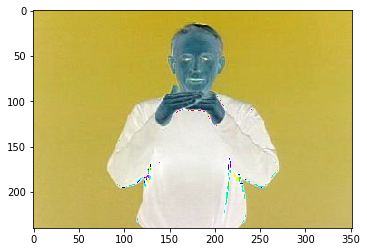

In [21]:
import matplotlib.pyplot as plt
print(xb.shape)
plt.imshow(xb[3,:,:,:])
plt.show()
